# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt

drive.mount('/content/drive')
dir = "/content/drive/My Drive/lin_reg.txt"
FOLDS = 5
D = np.loadtxt(dir, delimiter=',')
D = (D - D.mean())/D.std()
np.random.shuffle(D)

Mounted at /content/drive


При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [8]:
def mse1(y_hat, y, w, b, a):
    loss = (((y_hat - y)**2).sum() + (a*(w**2).sum() + (b**2).sum())/2)/y.shape[0]
    return loss


def lin_f1(x, w, b):
    y_hat = np.dot(x, w) + b
    return y_hat


def get_grads(y_hat, x, y, w, b, alpha):
    w_grad = (np.dot((-2*(y - y_hat)).T, x) + alpha*2*w.sum())/y.shape[0]
    b_grad = (-2*(y - y_hat).sum() + alpha*2*b)/y.shape[0]
    return w_grad.T, b_grad


def split_data(D, prop):
    n = round(len(D)*prop)
    return D[:n, :-1], D[n:, :-1], D[:n, -1], D[n:, -1]


def CV_data(d, f):
    lst = []
    for i in range(f):
      lst.append(d[i*len(d)//f: (i+1)*len(d)//f])
    return lst

<h1> Пункт 1 </h2>

Text(0, 0.5, 'loss')

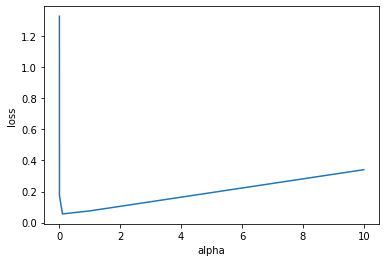

In [6]:
N_EPOCHS = 1000
LEARNING_RATE = 0.01

np.random.seed(123)
weights = np.random.random((D.shape[1]-1, 1))
bias = np.random.random((1, 1))
alphas = [0.0001, 0.001, 0.1, 1.0, 10]

X_train, X_test, Y_train, Y_test = split_data(D, 0.8)
Y_train, Y_test = Y_train.reshape((len(Y_train), 1)), Y_test.reshape((len(Y_test), 1)) 

losses = []

for alpha in alphas:
  for epoch in range(N_EPOCHS):
      y_hat = lin_f1(X_train, weights, bias).reshape((len(Y_train), 1))
      loss = mse1(y_hat, Y_train, weights, bias, alpha)
      
      w_grad, b_grad = get_grads(y_hat, X_train, Y_train, weights, bias, alpha)
      weights -= w_grad*LEARNING_RATE
      bias -= b_grad*LEARNING_RATE
  
  y_hat = lin_f1(X_test, weights, bias).reshape((len(Y_test), 1))
  loss = mse1(y_hat, Y_test, weights, bias, alpha)
  losses.append(loss)
        

plt.plot(alphas, losses[::-1])
plt.xlabel('alpha')
plt.ylabel('loss')

<h1> Пункты 2-5 </h1>

In [9]:
N_EPOCHS = 1000
LEARNING_RATE = 0.01
FOLDS = 5

np.random.seed(123)
weights = np.random.random((D.shape[1]-1, 1))
bias = np.random.random((1, 1))
alphas = np.arange(0, 0.1, 0.002)

cv = CV_data(D, FOLDS)
train_losses = []
test_losses = []

for alpha in alphas:

  local_train_losses = np.array([])
  local_test_losses = np.array([])

  for i in range(FOLDS):

    D_train, D_test = np.vstack(tuple(cv[:i] + cv[i+1:])), cv[i]
    X_train, Y_train = D_train[:, :-1], D_train[:, -1]
    X_test, Y_test = D_test[:, :-1], D_test[:, -1]
    Y_train, Y_test = Y_train.reshape((len(Y_train), 1)), Y_test.reshape((len(Y_test), 1)) 
    
    for epoch in range(N_EPOCHS):

      y_hat = lin_f1(X_train, weights, bias).reshape((len(Y_train), 1))
      loss = mse1(y_hat, Y_train, weights, bias, alpha)

      if epoch == N_EPOCHS - 1:
        local_train_losses = np.append(local_train_losses, loss)
      
      w_grad, b_grad = get_grads(y_hat, X_train, Y_train, weights, bias, alpha)
      weights -= w_grad*LEARNING_RATE
      bias -= b_grad*LEARNING_RATE
  
    y_hat = lin_f1(X_test, weights, bias).reshape((len(Y_test), 1))
    loss = mse1(y_hat, Y_test, weights, bias, alpha)
    local_test_losses = np.append(local_test_losses, loss)
  
  train_losses.append(local_train_losses.mean())
  test_losses.append(local_test_losses.mean())

In [10]:
idx = list.index(test_losses, min(test_losses))
print('Оптимальное значение параметра alpha на сетке arange(0, 0.1, 0.002):', alphas[idx])

Оптимальное значение параметра alpha на сетке arange(0, 0.1, 0.002): 0.002


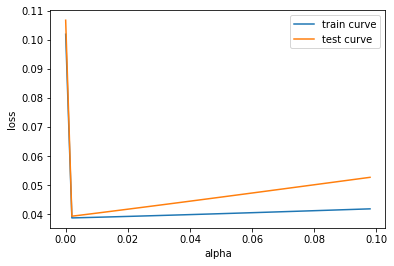

In [11]:
plt.plot(alphas, train_losses, label='train curve')
plt.plot(alphas, test_losses, label='test curve')

plt.ylabel('loss')
plt.xlabel('alpha')
plt.legend()